In [1]:
from fastai import *
from fastai.tabular import *
from fastai.text import *

In [2]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import Counter
import random

In [4]:
path = '/floyd/home/notebooks'
data_path = '/floyd/home/data'
model_path = '/floyd/home/models'

In [6]:
df1 = pd.read_csv(data_path +'/targets.csv', index_col=0)
df2 = pd.read_csv(data_path + '/subj_data.csv', index_col=0)
data = pd.concat([df1,df2],axis = 1)

In [7]:
len(data)

136993

In [8]:
data.head()

,Unnamed: 0,service,target2,target,outcome,discharge,dispo,Unnamed: 0,MedicalHistory,SubjectiveNotes
0,0,discharge,1,1,discharge,1,NaN,0,NaN,NaN
1,1,discharge,1,1,discharge,1,NaN,1,NaN,NaN
2,2,discharge,1,1,discharge,1,NaN,2,NaN,NaN
3,3,discharge,1,1,discharge,1,NaN,3,NaN,NaN
4,4,discharge,1,1,discharge,1,NaN,4,NaN,NaN


In [11]:
data.dropna(subset = ['SubjectiveNotes'], inplace = True)
len(data)

110874

In [12]:
for note in list(data['SubjectiveNotes'])[:10]:
    print (note)

^c^^^^ctasSUN=pt states that she feels shaky.  pt denies any pain.
^c^^^^ctasSUN=
^c^^^^ctasSUN=Pt states no pain.
^c^^^^ctasSUN=denied chest pain
^c^^^^ctasSUN=Denies pain. Eating ED lunch at triage
^c^^^^ctasSUN=pt. c/o pain  on the left wrist and left ankle , no obvious deformity , with minor laceration  in between left thumb, and  2nd digit left finger .
^c^^^^ctasSUN=The patient states his pain is manageable. Still shivering-patient was laying on a cold concrete floor. Denies any other injuries other then the left leg.
^c^^^^ctasSUN=As per the police the patient-was having an agressive altercation with his mother.  The patient was to have mentioned to a call taker that he was suicidal.  The patient has a his of autism and some behaviour issues.
^c^^^^ctasSUN=pt states feels weak, c/o pain to feet x 3-4 days, nauseated
^c^^^^ctasSUN=c/o pain of frontal headache, continues to c/o generalized body pain.


In [13]:
#this field is to strip the leading characters from the subjective notes field
data['subj'] = data['SubjectiveNotes'].str[14:]

In [14]:
data.head()

,Unnamed: 0,service,target2,target,outcome,discharge,dispo,Unnamed: 0,MedicalHistory,SubjectiveNotes,subj
148,148,discharge,1,1,discharge,1,NaN,148,^c^^^^ctasMEHPL=No Significant Medical History,^c^^^^ctasSUN=pt states that she feels shaky. ...,pt states that she feels shaky. pt denies any...
156,156,discharge,1,1,discharge,1,NaN,156,^c^^^^ctasMEHPL=Substance Misuse,^c^^^^ctasSUN=,
197,197,discharge,1,1,discharge,1,NaN,197,^c^^^^ctasMEHPL=No Significant Medical History,^c^^^^ctasSUN=Pt states no pain.,Pt states no pain.
217,217,discharge,1,1,discharge,1,NaN,217,^c^^^^ctasMEHPL=No Significant Medical History,^c^^^^ctasSUN=denied chest pain,denied chest pain
218,218,discharge,1,1,discharge,1,NaN,218,^c^^^^ctasMEHPL=Dialysis Haemo/PD<LT>LF>IDDM (...,^c^^^^ctasSUN=Denies pain. Eating ED lunch at ...,Denies pain. Eating ED lunch at triage


In [15]:
#and this drops some fields that were empty after stripping the leading characters
data = data[data['subj'] != '']

In [16]:
len(data)

110457

In [17]:
outcome_count = Counter(data['outcome']); outcome_count

Counter({'discharge': 99885, 'sadmit': 1567, 'madmit': 8361, 'ICU': 644})

In [19]:
service_count = Counter(data['service']); service_count

Counter({'discharge': 99885, 'sadmit': 1829, 'madmit': 8549, 'ICU': 194})

In [22]:
#this is a language model databunch from the entire dataset
data_lm = load_data(model_path,'large_lm')

In [26]:
data_clas_full = (TextList.from_df(data, cols='subj',vocab=data_lm.vocab)
                   .split_by_rand_pct(0.2)
                   .label_from_df(cols = 'outcome')
                   .databunch())

saving the large classifier databunch...

In [28]:
data_clas_full.save(model_path + '/full_clas_db')

Now on to training the classifier

In [33]:
f1 = FBeta(beta=1, average = 'weighted')
def train_triage_classifier(encoder_name, datac = data_clas_full, datal = data_lm, 
                            mets = [accuracy,f1], num_cycles = 1, lr = 1e-2, drop_mult = 0.5):
    model = text_classifier_learner(datac, metrics = mets, arch = AWD_LSTM, drop_mult=drop_mult)
    model.load_encoder(model_path + '/' + encoder_name)
    model.fit_one_cycle(num_cycles, lr, moms=(0.8,0.7))
    model.freeze_to(-2)
    model.fit_one_cycle(num_cycles, slice(lr/(2.6**4),lr), moms=(0.8,0.7))
    model.freeze_to(-3)
    model.fit_one_cycle(num_cycles, slice((lr/2)/(2.6**4),(lr/2)), moms=(0.8,0.7))
    model.unfreeze()
    model.fit_one_cycle(num_cycles*5, slice((lr/100)/(2.6**4),(lr/100)), moms=(0.8,0.7))
    model.recorder.plot_losses()
    return model

#### training classifier (I am using the full dataset here)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.325037,0.326482,0.903083,0.859870,04:05


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.333564,0.319306,0.903490,0.862087,04:52


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.310981,0.316502,0.903762,0.862217,07:25


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.309803,0.315701,0.903988,0.863279,10:13
1,0.304975,0.315680,0.903762,0.863265,10:02
2,0.313507,0.315853,0.903898,0.862960,10:17
3,0.302416,0.315710,0.903762,0.863609,10:03
4,0.313738,0.315649,0.904079,0.863228,09:34


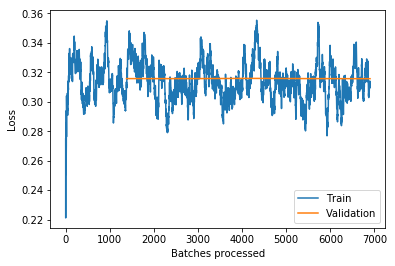

In [41]:
sent_learn = train_triage_classifier('edsent_v2_enc2', datac = data_clas_full, num_cycles = 1, lr = 1e-3)

In [42]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

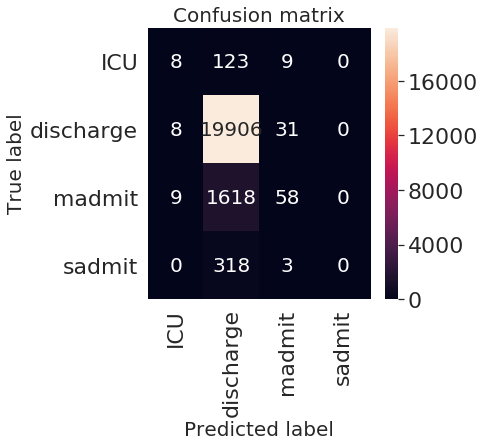

In [44]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

LABELS = data_clas_full.classes

confusion_matrix = metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [47]:
sent_learn.save(model_path + '/edtriage2')

so the results above show high accuracy and f-score, but very few admission predictions

now gonna train longer and see what happens

In [46]:
data_clas_full2 = (TextList.from_df(data, cols='subj',vocab=data_lm.vocab)
                   .split_by_rand_pct(0.2)
                   .label_from_df(cols = 'service')
                   .databunch())

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.323382,0.318309,0.904214,0.864396,03:57
1,0.290085,0.306193,0.904984,0.863604,03:54
2,0.337687,0.303845,0.904984,0.863285,04:05


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.306796,0.305917,0.904577,0.863555,04:51
1,0.314900,0.300065,0.905074,0.865789,04:39
2,0.276908,0.299801,0.905074,0.866325,04:46


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.284210,0.299914,0.905074,0.868041,07:31
1,0.286468,0.299472,0.905165,0.866765,07:31
2,0.283946,0.298888,0.904893,0.867925,07:32


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.270205,0.298970,0.904622,0.867437,10:06
1,0.288500,0.299180,0.905165,0.866894,09:40
2,0.294971,0.298831,0.905029,0.867654,09:57
3,0.271473,0.298987,0.904622,0.868204,09:34
4,0.276894,0.298771,0.904848,0.867567,10:16
5,0.281706,0.298766,0.904667,0.868109,10:07
6,0.298027,0.298452,0.905346,0.867719,10:08
7,0.272918,0.298930,0.904577,0.868088,10:19
8,0.294623,0.298981,0.905210,0.867319,09:41
9,0.301512,0.298809,0.904984,0.867493,09:39


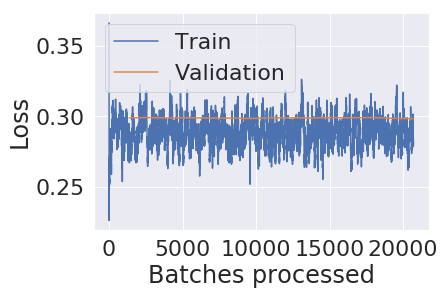

In [48]:
sent_learn = train_triage_classifier('edsent_v2_enc2', datac = data_clas_full2, num_cycles = 3, lr = 1e-3)

In [49]:
sent_learn.save(model_path + '/edtriage3')

In [50]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

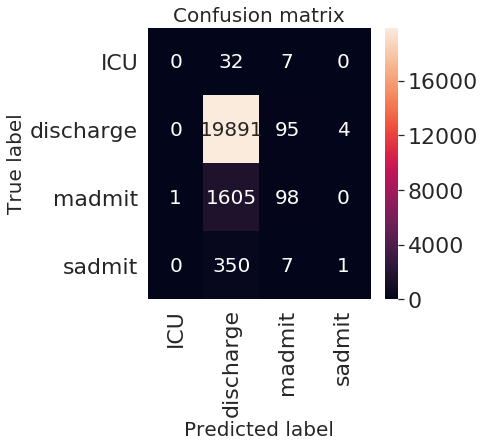

In [51]:
confusion_matrix = metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

this was a little worse because it overfit the data

In [26]:
data_lm2 = load_data(path, 'large_lm')
data_clas2 = load_data(path, 'large_clas_db')

In [12]:
model = text_classifier_learner(data_clas2, arch = AWD_LSTM, drop_mult=0.5)

In [14]:
model.load(path + '/models/edtriage1');

In [15]:
model.summary()

Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [51, 400]            0          False     
______________________________________________________________________
RNNDropout           [51, 1150]           0          False     
______________________________________________________________________
RNNDropout           [51, 1150]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
______________________________________________________________

In [17]:
preds, targets = model.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

In [19]:
f1_scores = metrics.f1_score(targets, predictions, average = None)

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
f1_scores

array([0.      , 0.948519, 0.042424, 0.      ])

In [22]:
f1_scores2 = metrics.f1_score(targets, predictions, average = 'weighted')

In [23]:
f1_scores2

0.8596056157360306

In [28]:
f1_scores3 = metrics.f1_score(targets, predictions, average = 'macro'); f1_scores3

0.2477357511919724

In [29]:
acc = metrics.accuracy_score(targets, predictions); acc

0.90225

so clearly we overfit long before we get good.  let's try this again, but we will do shorter training and more dropout

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.571676,0.503379,0.897750,0.857699,00:41


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.371055,0.344525,0.902500,0.857446,00:50


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.344041,0.336515,0.902750,0.858046,01:20


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.321526,0.335079,0.902750,0.858512,01:45
1,0.310394,0.335478,0.902750,0.858512,01:45
2,0.316377,0.336074,0.903000,0.859105,01:45
3,0.337970,0.334975,0.903000,0.858643,01:45
4,0.328497,0.335041,0.903000,0.858175,01:45


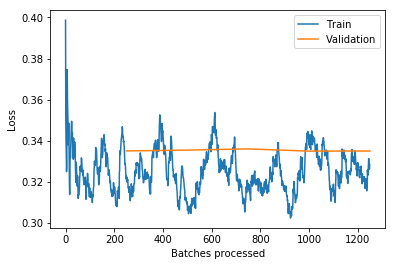

In [34]:
sent_learn = train_triage_classifier('edsent_v2_enc2', datac = data_clas2, num_cycles = 1, lr = 1e-3, drop_mult = 0.7)

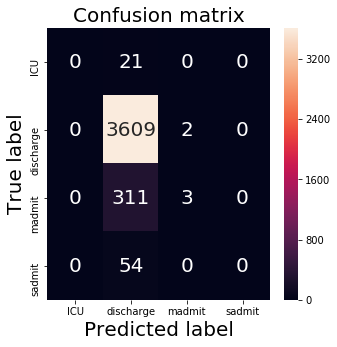

In [36]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

confusion_matrix = metrics.confusion_matrix(targets, predictions)
LABELS = data_clas2.classes

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

for interest sake I'm going to see what the model looks like before we do any training

In [37]:
model = text_classifier_learner(data_clas2, arch = AWD_LSTM, drop_mult=0.5)

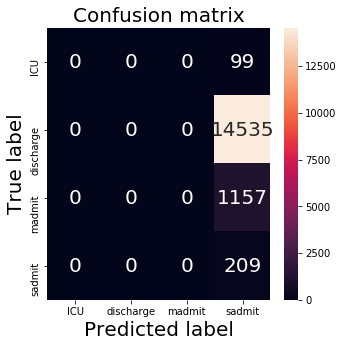

In [39]:
preds, targets = model.get_preds(DatasetType.Train) 
predictions = np.argmax(preds, axis = 1) 

confusion_matrix = metrics.confusion_matrix(targets, predictions)
LABELS = data_clas2.classes

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

Gonna try a new approach where I just train on admitted patients to see if I can distinguish them:

In [7]:
len(data)

110227

In [8]:
dc_data = data[data['outcome'] == 'discharge']

In [9]:
len(dc_data)

99885

In [10]:
admit_data = data[data['outcome'] != 'discharge']

In [12]:
len(admit_data)

10342

In [13]:
len(data) == len(dc_data) + len(admit_data)

True

In [14]:
dc_count = Counter(dc_data.outcome); dc_count

Counter({'discharge': 99885})

In [15]:
ad_count = Counter(admit_data.outcome); ad_count

Counter({'sadmit': 1565, 'madmit': 8136, 'ICU': 641})

In [17]:
dc_data.to_csv('discharges')

In [18]:
admit_data.to_csv('admissions')

In [19]:
data_lm2 = load_data(path, 'large_lm')

In [20]:
admit_clas = (TextList.from_df(admit_data, cols='subj',vocab=data_lm2.vocab)
                   .split_by_rand_pct(0.2)
                   .label_from_df(cols = 'outcome')
                   .databunch())

In [22]:
admit_clas.classes

['ICU', 'madmit', 'sadmit']

In [23]:
admit_clas.vocab.itos == data_lm2.vocab.itos

True

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.895672,0.804704,0.750484,0.749251,00:25


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.650800,0.605090,0.791586,0.766759,00:30


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.560469,0.541517,0.799807,0.761267,00:49


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.545893,0.542009,0.795938,0.757783,01:03
1,0.532714,0.540689,0.797389,0.759073,01:01
2,0.530488,0.540463,0.797872,0.763657,01:03
3,0.543008,0.539007,0.794004,0.755700,01:00
4,0.535125,0.540949,0.799323,0.762522,01:05


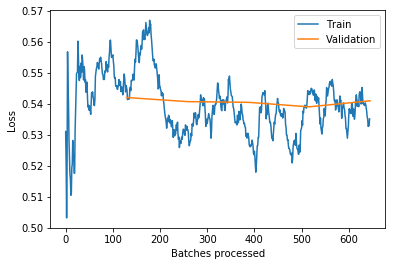

In [28]:
sent_learn = train_triage_classifier('edsent_v2_enc2', datac = admit_clas, num_cycles = 1, lr = 1e-3, drop_mult = 0.7)

In [30]:
txt_ci = TextClassificationInterpretation.from_learner(sent_learn)

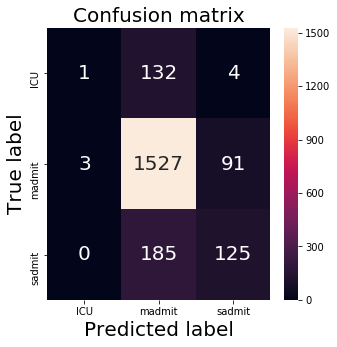

In [37]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

confusion_matrix = metrics.confusion_matrix(targets, predictions)
LABELS = admit_clas.classes

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

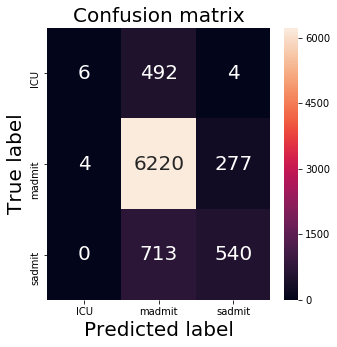

In [38]:
preds, targets = sent_learn.get_preds(DatasetType.Train) 
predictions = np.argmax(preds, axis = 1) 

confusion_matrix = metrics.confusion_matrix(targets, predictions)
LABELS = admit_clas.classes

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

still not very good.  gonne try to split again

gonna look at differentiating admitted patients between the ward and ICU

In [39]:
admit_data['ward/icu'] = admit_data['outcome'].map(
{'ICU': 'ICU',
 'madmit': 'ward',
 'sadmit' : 'ward',
 })

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [40]:
admit_data.head()

,Unnamed: 0,outcome,subj,ward/icu
5,6,sadmit,The patient states his pain is manageable. Sti...,ward
6,7,madmit,As per the police the patient-was having an ag...,ward
12,13,sadmit,States she was taking out the garbage when she...,ward
14,15,madmit,"C/o chest heaviness, with sweating. Pt. denies...",ward
20,21,madmit,pt denies any pain.,ward


In [41]:
count3 = Counter(admit_data['ward/icu']); count3

Counter({'ward': 9701, 'ICU': 641})

In [43]:
floor_clas = (TextList.from_df(admit_data, cols='subj',vocab=data_lm2.vocab)
                   .split_by_rand_pct(0.2)
                   .label_from_df(cols = 'ward/icu')
                   .databunch())

In [44]:
floor_clas.classes

['ICU', 'ward']

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.546206,0.493368,0.878143,0.892003,00:25


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.328051,0.284913,0.936170,0.916652,00:31


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.234372,0.234789,0.937137,0.917226,00:47


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.227766,0.227815,0.939072,0.918381,01:02
1,0.230966,0.227435,0.939072,0.918381,01:02
2,0.225872,0.226474,0.938588,0.918091,01:07
3,0.219498,0.225829,0.939072,0.918381,01:02
4,0.223254,0.228208,0.938104,0.917803,01:00


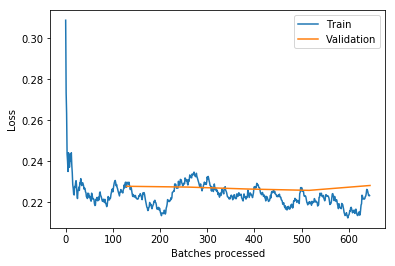

In [45]:
sent_learn = train_triage_classifier('edsent_v2_enc2', datac = floor_clas, num_cycles = 1, lr = 1e-3, drop_mult = 0.5)

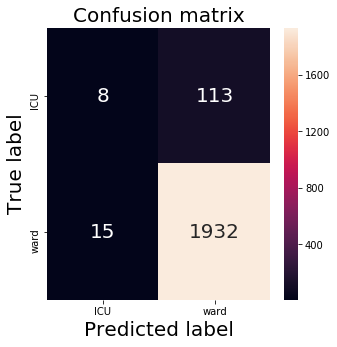

In [46]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

confusion_matrix = metrics.confusion_matrix(targets, predictions)
LABELS = floor_clas.classes

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [51]:
f_score = metrics.f1_score(targets, predictions, average = 'binary')

In [52]:
f_score

0.9679358717434869

In [53]:
f_score = metrics.f1_score(targets, predictions, average = None)

In [54]:
f_score

array([0.111111, 0.967936])

#### this is not bad by the numbers but doesn't detect the outlier (ICU admission) very well

now gonna try admit vs. d/c

In [55]:
data['admission'] = data['outcome'].map(
{'ICU': 'admit',
 'madmit': 'admit',
 'sadmit' : 'admit',
 'discharge' : 'discharge'
 })

In [ ]:
admit_data['ward/icu'] = admit_data['outcome'].map(
{'ICU': 'ICU',
 'madmit': 'ward',
 'sadmit' : 'ward',
 })

In [56]:
data_clas = (TextList.from_df(data, cols='subj',vocab=data_lm2.vocab)
                   .split_by_rand_pct(0.2)
                   .label_from_df(cols = 'admission')
                   .databunch())

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.260799,0.258465,0.909957,0.871546,04:03


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.269608,0.253495,0.910048,0.873052,04:55


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.258076,0.253368,0.910955,0.875721,07:39


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.246777,0.252684,0.910683,0.874907,10:46
1,0.275943,0.252002,0.910229,0.873308,09:58
2,0.271188,0.252132,0.910501,0.874360,10:39
3,0.250602,0.251676,0.910229,0.873532,09:59
4,0.268198,0.251902,0.911046,0.876418,10:48


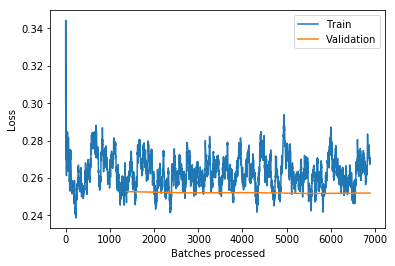

In [57]:
sent_learn = train_triage_classifier('edsent_v2_enc2', datac = data_clas, num_cycles = 1, lr = 1e-3, drop_mult = 0.5)

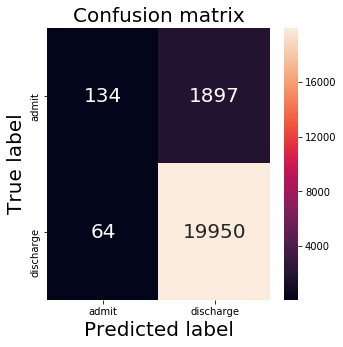

In [58]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

confusion_matrix = metrics.confusion_matrix(targets, predictions)
LABELS = data_clas.classes

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

same old problem.  good numbers but not very useful predictions